In [ ]:
#pip install -U  pyspark

In [1]:
import pyspark

print(f"PySpark version in your code: {pyspark.__version__}")



PySpark version in your code: 3.5.1


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Project") \
    .master("local[*]") \
    .config("spark.driver.memory", "30g") \
    .config("spark.executor.memory", "20g") \
    .config("spark.executor.cores", 8) \
    .config("spark.cores.max", 48) \
    .config("spark.sql.shuffle.partitions", 128) \
    .config("spark.network.timeout", "800s") \
    .getOrCreate()

In [2]:
spark

In [2]:
from pyspark.sql.functions import col, when, regexp_replace
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import numpy as np
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import lit, col, monotonically_increasing_id
from sklearn.metrics import classification_report
from functools import reduce
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import MulticlassMetrics
from scipy.interpolate import interp1d
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count

C:\Anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Load header file
header_path = "C:/Users/psxtm7/Downloads/test_set.arff/test_set.arff/test_set.header"          
header_lines = spark.sparkContext.textFile(header_path).collect()

In [4]:
# Displaying header data
header_lines

['@relation PSSM+PredSS+PredSA+PredRCH+CM',
 '@attribute separation real',
 '@attribute propensity real',
 '@attribute length real',
 '@attribute PredSS_r1_-4 {H,E,C,X}',
 '@attribute PredSS_r1_-3 {H,E,C,X}',
 '@attribute PredSS_r1_-2 {H,E,C,X}',
 '@attribute PredSS_r1_-1 {H,E,C,X}',
 '@attribute PredSS_r1 {H,E,C}',
 '@attribute PredSS_r1_1 {H,E,C,X}',
 '@attribute PredSS_r1_2 {H,E,C,X}',
 '@attribute PredSS_r1_3 {H,E,C,X}',
 '@attribute PredSS_r1_4 {H,E,C,X}',
 '@attribute PredSS_r2_-4 {H,E,C,X}',
 '@attribute PredSS_r2_-3 {H,E,C,X}',
 '@attribute PredSS_r2_-2 {H,E,C,X}',
 '@attribute PredSS_r2_-1 {H,E,C,X}',
 '@attribute PredSS_r2 {H,E,C}',
 '@attribute PredSS_r2_1 {H,E,C,X}',
 '@attribute PredSS_r2_2 {H,E,C,X}',
 '@attribute PredSS_r2_3 {H,E,C,X}',
 '@attribute PredSS_r2_4 {H,E,C,X}',
 '@attribute PredSS_freq_central_H real',
 '@attribute PredSS_freq_central_E real',
 '@attribute PredSS_freq_central_C real',
 '@attribute PredCN_freq_central_0 real',
 '@attribute PredCN_freq_central_

In [4]:
# Extracting attribute names from header
attribute_names = [line.strip().split()[1] for line in header_lines if line.strip().startswith("@attribute")]
attribute_names

['separation',
 'propensity',
 'length',
 'PredSS_r1_-4',
 'PredSS_r1_-3',
 'PredSS_r1_-2',
 'PredSS_r1_-1',
 'PredSS_r1',
 'PredSS_r1_1',
 'PredSS_r1_2',
 'PredSS_r1_3',
 'PredSS_r1_4',
 'PredSS_r2_-4',
 'PredSS_r2_-3',
 'PredSS_r2_-2',
 'PredSS_r2_-1',
 'PredSS_r2',
 'PredSS_r2_1',
 'PredSS_r2_2',
 'PredSS_r2_3',
 'PredSS_r2_4',
 'PredSS_freq_central_H',
 'PredSS_freq_central_E',
 'PredSS_freq_central_C',
 'PredCN_freq_central_0',
 'PredCN_freq_central_1',
 'PredCN_freq_central_2',
 'PredCN_freq_central_3',
 'PredCN_freq_central_4',
 'PredRCH_freq_central_0',
 'PredRCH_freq_central_1',
 'PredRCH_freq_central_2',
 'PredRCH_freq_central_3',
 'PredRCH_freq_central_4',
 'PredSA_freq_central_0',
 'PredSA_freq_central_1',
 'PredSA_freq_central_2',
 'PredSA_freq_central_3',
 'PredSA_freq_central_4',
 'PredRCH_r1_-4',
 'PredRCH_r1_-3',
 'PredRCH_r1_-2',
 'PredRCH_r1_-1',
 'PredRCH_r1',
 'PredRCH_r1_1',
 'PredRCH_r1_2',
 'PredRCH_r1_3',
 'PredRCH_r1_4',
 'PredRCH_r2_-4',
 'PredRCH_r2_-3',
 'P

In [5]:
# Defining schema for the DataFrame
schema = StructType([StructField(attr_name, StringType(), True) for attr_name in attribute_names])

In [6]:
# Loading the test body data
test_body_df = spark.read.format("csv").load("C:/Users/psxtm7/Downloads/test_set.arff/test_set.arff/test_set.body").sample(withReplacement=False, fraction=0.005, seed=42)
# Applying schema to the test_body_df
df = spark.createDataFrame(test_body_df.rdd, schema)

# Merging the two DataFrames
df0 = df

In [7]:
# Checking the number of partitions in the DataFrame
num_partitions = df0.rdd.getNumPartitions()
print("Number of partitions:", num_partitions)

Number of partitions: 42


In [8]:
 # Repartition the data into partitions
df0 = df0.repartition(num_partitions)

In [9]:
# Caching the DataFrame
df0.cache()

DataFrame[separation: string, propensity: string, length: string, PredSS_r1_-4: string, PredSS_r1_-3: string, PredSS_r1_-2: string, PredSS_r1_-1: string, PredSS_r1: string, PredSS_r1_1: string, PredSS_r1_2: string, PredSS_r1_3: string, PredSS_r1_4: string, PredSS_r2_-4: string, PredSS_r2_-3: string, PredSS_r2_-2: string, PredSS_r2_-1: string, PredSS_r2: string, PredSS_r2_1: string, PredSS_r2_2: string, PredSS_r2_3: string, PredSS_r2_4: string, PredSS_freq_central_H: string, PredSS_freq_central_E: string, PredSS_freq_central_C: string, PredCN_freq_central_0: string, PredCN_freq_central_1: string, PredCN_freq_central_2: string, PredCN_freq_central_3: string, PredCN_freq_central_4: string, PredRCH_freq_central_0: string, PredRCH_freq_central_1: string, PredRCH_freq_central_2: string, PredRCH_freq_central_3: string, PredRCH_freq_central_4: string, PredSA_freq_central_0: string, PredSA_freq_central_1: string, PredSA_freq_central_2: string, PredSA_freq_central_3: string, PredSA_freq_central_

In [11]:
df0.show(10)

+----------+------------------+------+------------+------------+------------+------------+---------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+---------+-----------+-----------+-----------+-----------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------+-------------+-------------+-------------+----------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+----------+------------+------------+------------+------------+------------+------------+------------+------------+---------+-----------+-----------+-----------+-----

In [12]:
# Counting the total number of rows
total_rows = df0.count()
# Printing the total number of rows
print("Total number of rows:", total_rows)

Total number of rows: 14637


In [13]:
df0.printSchema()

root
 |-- separation: string (nullable = true)
 |-- propensity: string (nullable = true)
 |-- length: string (nullable = true)
 |-- PredSS_r1_-4: string (nullable = true)
 |-- PredSS_r1_-3: string (nullable = true)
 |-- PredSS_r1_-2: string (nullable = true)
 |-- PredSS_r1_-1: string (nullable = true)
 |-- PredSS_r1: string (nullable = true)
 |-- PredSS_r1_1: string (nullable = true)
 |-- PredSS_r1_2: string (nullable = true)
 |-- PredSS_r1_3: string (nullable = true)
 |-- PredSS_r1_4: string (nullable = true)
 |-- PredSS_r2_-4: string (nullable = true)
 |-- PredSS_r2_-3: string (nullable = true)
 |-- PredSS_r2_-2: string (nullable = true)
 |-- PredSS_r2_-1: string (nullable = true)
 |-- PredSS_r2: string (nullable = true)
 |-- PredSS_r2_1: string (nullable = true)
 |-- PredSS_r2_2: string (nullable = true)
 |-- PredSS_r2_3: string (nullable = true)
 |-- PredSS_r2_4: string (nullable = true)
 |-- PredSS_freq_central_H: string (nullable = true)
 |-- PredSS_freq_central_E: string (nullab

In [14]:
# Checking the schema to identify categorical columns
categorical_columns = [col_name for col_name, col_type in df0.dtypes if col_type == "string"]
print("Number of Categorical Columns:", len(categorical_columns))

Number of Categorical Columns: 632


In [15]:
# Checking the class distribution

class_counts = df0.groupBy("class").count()
class_counts.select("class", "count").show()

+-----+-----+
|class|count|
+-----+-----+
|    0|14388|
|    1|  249|
+-----+-----+



In [11]:
def check_null_values(df):

    # Counting null values for each column
    null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

    # Printing column names with null values and their counts
    null_counts.show(truncate=False)


check_null_values(df0)

+----------+----------+------+------------+------------+------------+------------+---------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+---------+-----------+-----------+-----------+-----------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------+-------------+-------------+-------------+----------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+----------+------------+------------+------------+------------+------------+------------+------------+------------+---------+-----------+-----------+-----------+-----------+-

In [10]:
# Taking first element from the whole dataset and storing it in python dictionary

first=df0.first().asDict()

In [11]:
# Iterating over the dictionary to check for numerical and string columns
import re

int_float_pattern = re.compile(r'^-?\d+(\.\d+)?$')
integer_columns = []
string_columns = []

for column, value in first.items():
    if int_float_pattern.match(str(value)):
        integer_columns.append(column)
    else:
        string_columns.append(column)


In [18]:
print(len(integer_columns))

609


In [12]:
# Casting the numerical columns list to float type

for column in integer_columns:
    df0 = df0.withColumn(column, regexp_replace(col(column), r"^\s*$", "null").cast(FloatType()))

In [21]:
# Checking the schema to identify categorical columns
categorical_columns = [col_name for col_name, col_type in df0.dtypes if col_type == "string"]
print("Number of Categorical Columns:", len(categorical_columns))

Number of Categorical Columns: 23


In [13]:
# Dropping null values in dataset if present
df0 = df0.dropna()

In [23]:
# Displaying the schema to verify changes
df0.printSchema()

root
 |-- separation: float (nullable = true)
 |-- propensity: float (nullable = true)
 |-- length: float (nullable = true)
 |-- PredSS_r1_-4: string (nullable = true)
 |-- PredSS_r1_-3: string (nullable = true)
 |-- PredSS_r1_-2: string (nullable = true)
 |-- PredSS_r1_-1: string (nullable = true)
 |-- PredSS_r1: string (nullable = true)
 |-- PredSS_r1_1: string (nullable = true)
 |-- PredSS_r1_2: string (nullable = true)
 |-- PredSS_r1_3: string (nullable = true)
 |-- PredSS_r1_4: string (nullable = true)
 |-- PredSS_r2_-4: string (nullable = true)
 |-- PredSS_r2_-3: string (nullable = true)
 |-- PredSS_r2_-2: string (nullable = true)
 |-- PredSS_r2_-1: string (nullable = true)
 |-- PredSS_r2: string (nullable = true)
 |-- PredSS_r2_1: string (nullable = true)
 |-- PredSS_r2_2: string (nullable = true)
 |-- PredSS_r2_3: string (nullable = true)
 |-- PredSS_r2_4: string (nullable = true)
 |-- PredSS_freq_central_H: float (nullable = true)
 |-- PredSS_freq_central_E: float (nullable = 

In [15]:
float_columns = [col_name for col_name, col_type in df0.dtypes if col_type == "float" and col_name != "class"]

# Assemble the float columns into a single feature vector
assembler = VectorAssembler(inputCols=float_columns, outputCol="features")
assembled_df = assembler.transform(df0).select("features")

# Computing the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features").head()[0]

# Converting the correlation matrix to a Pandas DataFrame for better visualization
correlation_df = pd.DataFrame(correlation_matrix.toArray(), columns=float_columns, index=float_columns)

# Identifying highly correlated features
highly_correlated_features = []
correlation_threshold = 0.7

for i in range(len(correlation_df.columns)):
    for j in range(i+1, len(correlation_df.columns)):
        if abs(correlation_df.iloc[i, j]) > correlation_threshold:
            highly_correlated_features.append(correlation_df.columns[i])



# Printing the number of highly correlated features
print("Number of highly correlated features:", len(highly_correlated_features))


Number of highly correlated features: 335


In [16]:
# Remove highly correlated features from dataset
df0 = df0.drop(*highly_correlated_features)

In [17]:
# String indexing
indexer = StringIndexer(inputCols=string_columns, outputCols=[col + "_indexed" for col in string_columns])

# One-hot encoding
output_cols = [col + "_encoded" for col in string_columns]
encoder = OneHotEncoder(inputCols=[col + "_indexed" for col in string_columns], outputCols=output_cols)

# Creating the pipeline
pipeline = Pipeline(stages=[indexer, encoder])

# Fitting and transforming the data
encoded_df = pipeline.fit(df0).transform(df0)

In [18]:
# Dropping columns after encoding
encoded_df = encoded_df.drop(*string_columns)

In [19]:
# Unpersisting the dataframe
df0.unpersist()

DataFrame[separation: float, propensity: float, length: float, PredSS_r1_-4: string, PredSS_r1_-3: string, PredSS_r1_-2: string, PredSS_r1_-1: string, PredSS_r1: string, PredSS_r1_1: string, PredSS_r1_2: string, PredSS_r1_3: string, PredSS_r1_4: string, PredSS_r2_-4: string, PredSS_r2_-3: string, PredSS_r2_-2: string, PredSS_r2_-1: string, PredSS_r2: string, PredSS_r2_1: string, PredSS_r2_2: string, PredSS_r2_3: string, PredSS_r2_4: string, PredSS_freq_central_C: float, PredCN_freq_central_1: float, PredCN_freq_central_3: float, PredRCH_freq_central_1: float, PredRCH_freq_central_3: float, PredSA_freq_central_3: float, PredSA_r1_-4: float, PredSS_freq_global_E: float, PredSS_freq_global_C: float, PredCN_freq_global_1: float, PredCN_freq_global_2: float, PredCN_freq_global_3: float, PredRCH_freq_global_1: float, PredRCH_freq_global_2: float, PredRCH_freq_global_3: float, PredSA_freq_global_1: float, PredSA_freq_global_2: float, PredSA_freq_global_3: float, PredSA_freq_global_4: float, A

In [30]:
# Printing the Schema for the Dataframe after removing correlated features and encoding.
encoded_df.printSchema()

root
 |-- separation: float (nullable = true)
 |-- propensity: float (nullable = true)
 |-- length: float (nullable = true)
 |-- PredSS_freq_central_C: float (nullable = true)
 |-- PredCN_freq_central_1: float (nullable = true)
 |-- PredCN_freq_central_3: float (nullable = true)
 |-- PredRCH_freq_central_1: float (nullable = true)
 |-- PredRCH_freq_central_3: float (nullable = true)
 |-- PredSA_freq_central_3: float (nullable = true)
 |-- PredSA_r1_-4: float (nullable = true)
 |-- PredSS_freq_global_E: float (nullable = true)
 |-- PredSS_freq_global_C: float (nullable = true)
 |-- PredCN_freq_global_1: float (nullable = true)
 |-- PredCN_freq_global_2: float (nullable = true)
 |-- PredCN_freq_global_3: float (nullable = true)
 |-- PredRCH_freq_global_1: float (nullable = true)
 |-- PredRCH_freq_global_2: float (nullable = true)
 |-- PredRCH_freq_global_3: float (nullable = true)
 |-- PredSA_freq_global_1: float (nullable = true)
 |-- PredSA_freq_global_2: float (nullable = true)
 |-- P

In [21]:
# Assembling the features into a vector
feature_cols = [col for col in encoded_df.columns if col != 'class']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(encoded_df)

In [22]:
# Training a Random Forest classifier
rf = RandomForestClassifier(labelCol="class", featuresCol="features")

# Fitting the model
model = rf.fit(assembled_data)

In [29]:
# Extracting feature importances
importances = model.featureImportances

# Creating a list of (feature, importance) tuples and sort it by importance
feature_importance_list = [(feature_cols[i], importances[i]) for i in range(len(feature_cols))]
sorted_feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

In [30]:
# Selecting top k features
num_features_to_select = 10  
selected_feature_cols = [feature[0] for feature in sorted_feature_importance_list[:num_features_to_select]]

# Updating the dataset with the selected features
updated_df = assembled_data.select(selected_feature_cols + ["class"])

In [31]:
# Printing the selected features and updated DataFrame schema
print("Selected features:", selected_feature_cols)
updated_df.printSchema()

Selected features: ['propensity', 'PSSM_r2_4_V', 'PSSM_r2_4_M', 'PSSM_r1_3_H', 'PSSM_r2_-2_M', 'PSSM_r1_2_C', 'length', 'PSSM_central_0_A', 'PredSA_freq_global_1', 'PSSM_r1_0_A']
root
 |-- propensity: float (nullable = true)
 |-- PSSM_r2_4_V: float (nullable = true)
 |-- PSSM_r2_4_M: float (nullable = true)
 |-- PSSM_r1_3_H: float (nullable = true)
 |-- PSSM_r2_-2_M: float (nullable = true)
 |-- PSSM_r1_2_C: float (nullable = true)
 |-- length: float (nullable = true)
 |-- PSSM_central_0_A: float (nullable = true)
 |-- PredSA_freq_global_1: float (nullable = true)
 |-- PSSM_r1_0_A: float (nullable = true)
 |-- class: float (nullable = true)



In [22]:
# Selected features: ['propensity', 'PSSM_r2_4_V', 'PSSM_r2_4_M', 'PSSM_r1_3_H',
# 'PSSM_r2_-2_M', 'PSSM_r1_2_C', 'length', 'PSSM_central_0_A', 'PredSA_freq_global_1', 'PSSM_r1_0_A']

# Selected features 
selected_feature_cols = ['propensity', 'PSSM_r2_4_V', 'PSSM_r2_4_M', 'PSSM_r1_3_H',
              'PSSM_r2_-2_M', 'PSSM_r1_2_C', 'length', 'PSSM_central_0_A', 'PredSA_freq_global_1', 'PSSM_r1_0_A']

# Updating the dataset with the selected features
updated_df = assembled_data.select(selected_feature_cols + ["class"])
updated_df.printSchema()

root
 |-- propensity: float (nullable = true)
 |-- PSSM_r2_4_V: float (nullable = true)
 |-- PSSM_r2_4_M: float (nullable = true)
 |-- PSSM_r1_3_H: float (nullable = true)
 |-- PSSM_r2_-2_M: float (nullable = true)
 |-- PSSM_r1_2_C: float (nullable = true)
 |-- length: float (nullable = true)
 |-- PSSM_central_0_A: float (nullable = true)
 |-- PredSA_freq_global_1: float (nullable = true)
 |-- PSSM_r1_0_A: float (nullable = true)
 |-- class: float (nullable = true)



In [42]:
# Splitting data into training and test sets
train_df, test_df = updated_df.randomSplit([0.8, 0.2], seed=42)

# Handling class imbalance using undersampling method
train_df = train_df.sampleBy("class", fractions={0: 0.02, 1: 1.0}, seed=42)

train_df = train_df.repartition(40)

In [43]:
# Assemble features and cache
feature_columns = updated_df.columns[:-1]  # Excluding the target column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_df = assembler.transform(train_df).select("features", "class").cache()
test_df = assembler.transform(test_df).select("features", "class").cache()

In [35]:
# Checking the class counts
grouped_df = train_df.groupBy("class").count()
grouped_df.show()

+-----+-----+
|class|count|
+-----+-----+
|  0.0|  209|
|  1.0|  177|
+-----+-----+



In [27]:

rf = RandomForestClassifier(featuresCol="features", labelCol="class")

# Defining hyperparameters
param_gridrf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [300,500]) \
    .addGrid(rf.maxDepth, [5,10]) \
    .addGrid(rf.minInstancesPerNode, [15,20]) \
    .build()

# cross-validation
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="class", metricName="accuracy")
cvrf = CrossValidator(estimator=rf, estimatorParamMaps=param_gridrf, evaluator=evaluator, numFolds=5)

In [28]:
# Fitting the cross-validator to the training data
cv_modelrf = cvrf.fit(train_df)

In [38]:
# Ectracting the best model
best_rf_model = cv_modelrf.bestModel
# Printing the best model's parameters
print("Best Model Parameters:")
print("Num Trees:", best_rf_model.getNumTrees)
print("Max depth:", best_rf_model.getMaxDepth())
print("Max instance:", best_rf_model.getMinInstancesPerNode())

Best Model Parameters:
Num Trees: 500
Max depth: 5
Max instance: 20


In [31]:
# Evaluating model on test set
predictionsrf = best_rf_model.transform(test_df)
evaluator1 = BinaryClassificationEvaluator(labelCol="class")
aucrf = evaluator1.evaluate(predictionsrf)
# Printing AUC
print("Area Under ROC:", aucrf)

Area Under ROC: 0.7530306235355375


In [32]:
# Printing classification report
y_true = predictionsrf.select("class").rdd.flatMap(lambda x: x).collect()
y_predrf = predictionsrf.select("prediction").rdd.flatMap(lambda x: x).collect()
print(classification_report(y_true, y_predrf))

              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83      2672
         1.0       0.04      0.63      0.07        46

    accuracy                           0.72      2718
   macro avg       0.51      0.67      0.45      2718
weighted avg       0.98      0.72      0.82      2718



C:\Anaconda3\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


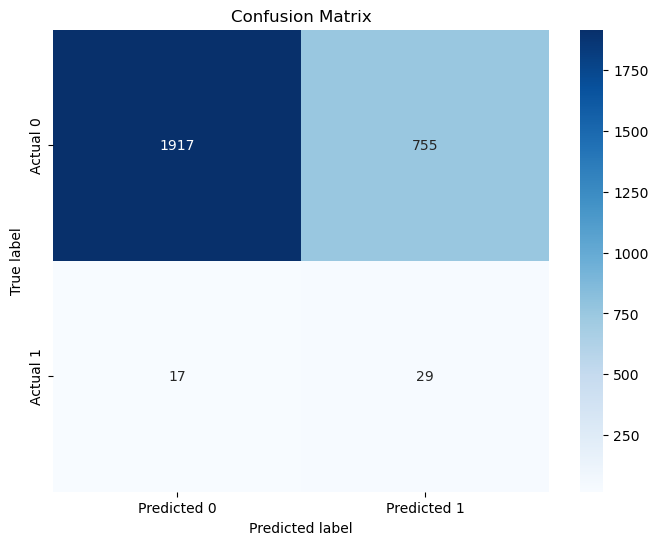

In [33]:
# Confusion Matrix for Random Forest

# Converting predictions to RDD for MulticlassMetrics
prediction_and_labelrf = predictionsrf.select("prediction", "class").rdd.map(lambda x: (x[0], x[1]))

# MulticlassMetrics
metricsrf = MulticlassMetrics(prediction_and_labelrf)

# Calculating confusion matrix
cmrf = metricsrf.confusionMatrix().toArray()

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmrf, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [43]:
from pyspark.ml.classification import GBTClassifier


# GBT Classifier
gbt = GBTClassifier(featuresCol="features", labelCol="class")

# Defining the hyperparameter grid
param_gridgbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5,10]) \
    .addGrid(gbt.maxIter, [20])\
    .addGrid(gbt.maxBins, [32, 64]) \
    .build()



# cross-validation and Evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="class", metricName="accuracy")
cvgbt = CrossValidator(estimator=gbt, estimatorParamMaps=param_gridgbt, evaluator=evaluator, numFolds=5)

In [44]:
# Fitting the cross-validator to the training data
cv_modelgbt = cvgbt.fit(train_df)

In [45]:
# Extracting the best model from cross-validation
best_gbt_model = cv_modelgbt.bestModel

# Printing the best parameters
print("Best parameters:")
print(f"\tmax_depth: {best_gbt_model.getMaxDepth()}")
print(f"\tmaxBins: {best_gbt_model.getMaxBins()}") 


Best parameters:
	max_depth: 5
	maxBins: 64


In [46]:
# Evaluating model on test set
predictionsgbt = best_gbt_model.transform(test_df)
evaluator1 = BinaryClassificationEvaluator(labelCol="class")
aucgbt = evaluator1.evaluate(predictionsgbt)
# Printing AUC
print("Area Under ROC:", aucgbt)

Area Under ROC: 0.7303924759177298


In [47]:
# Printing classification report
y_true = predictionsgbt.select("class").rdd.flatMap(lambda x: x).collect()
y_predgbt = predictionsgbt.select("prediction").rdd.flatMap(lambda x: x).collect()
print(classification_report(y_true, y_predgbt))

              precision    recall  f1-score   support

         0.0       0.99      0.65      0.79      2672
         1.0       0.03      0.67      0.06        46

    accuracy                           0.65      2718
   macro avg       0.51      0.66      0.42      2718
weighted avg       0.98      0.65      0.77      2718



C:\Anaconda3\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


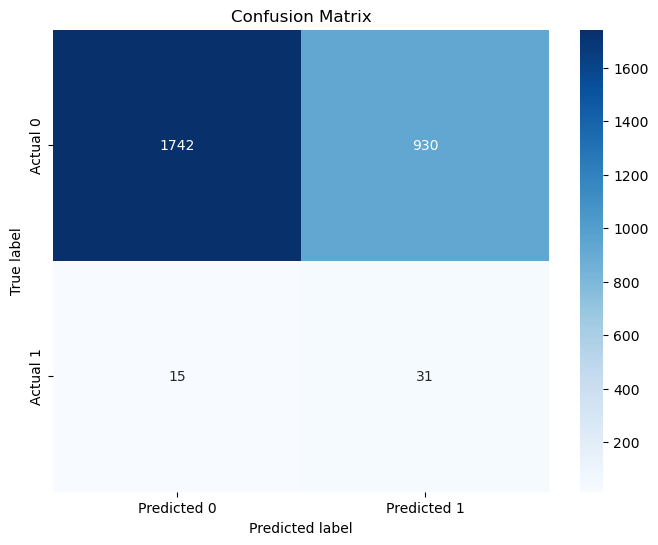

In [48]:
# Confusion matrix for GBT classifier

# Converting predictions to RDD for MulticlassMetrics
prediction_and_labelgbt = predictionsgbt.select("prediction", "class").rdd.map(lambda x: (x[0], x[1]))

# MulticlassMetrics
metricsgbt = MulticlassMetrics(prediction_and_labelgbt)

# Calculating confusion matrix
cmgbt = metricsgbt.confusionMatrix().toArray()

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmgbt, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [49]:
lr = LogisticRegression(featuresCol="features", labelCol="class")

# Logistic Regression
param_gridlr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0, 10.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
cvlr = CrossValidator(estimator=lr, estimatorParamMaps=param_gridlr, evaluator=evaluator, numFolds=5)

In [50]:
# Fitting the cross-validator to the training data
cv_modellr = cvlr.fit(train_df)

In [51]:
# Extracting the best model from cross-validation
best_lr_model = cv_modellr.bestModel

# Printing the best parameters
print("Best parameters:")
print("max_depth:", best_lr_model.getRegParam())
print("min_child_weight:", best_lr_model.getRegParam())


Best parameters:
max_depth: 0.01
min_child_weight: 0.01


In [52]:
# Evaluating model on test set
predictionslr = best_lr_model.transform(test_df)
auclr = evaluator1.evaluate(predictionslr)
# Printing AUC
print("Area Under ROC:", auclr)

Area Under ROC: 0.7301402629523562


In [53]:
# Printing classification report
y_true = predictionslr.select("class").rdd.flatMap(lambda x: x).collect()
y_predlr = predictionslr.select("prediction").rdd.flatMap(lambda x: x).collect()
print(classification_report(y_true, y_predlr))

              precision    recall  f1-score   support

         0.0       0.99      0.67      0.80      2672
         1.0       0.03      0.65      0.06        46

    accuracy                           0.67      2718
   macro avg       0.51      0.66      0.43      2718
weighted avg       0.97      0.67      0.78      2718



C:\Anaconda3\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


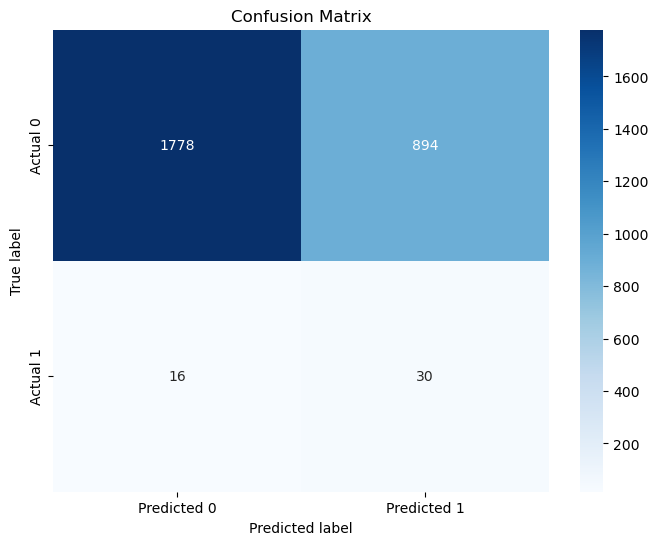

In [54]:
# Conufusion matrix for logistic regression

# Converting predictions to RDD for MulticlassMetrics
prediction_and_labellr = predictionslr.select("prediction", "class").rdd.map(lambda x: (x[0], x[1]))

# MulticlassMetrics
metricslr = MulticlassMetrics(prediction_and_labellr)

# Calculating confusion matrix
cmlr = metricslr.confusionMatrix().toArray()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmlr, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [89]:
# Converting predictions and labels to RDD format
rf_rdd = predictionsrf.select(['probability', 'class']).rdd.map(lambda row: (float(row['probability'][1]), row['class'])).collect()
gbt_rdd = predictionsgbt.select(['probability', 'class']).rdd.map(lambda row: (float(row['probability'][1]), row['class'])).collect()
lr_rdd = predictionslr.select(['probability', 'class']).rdd.map(lambda row: (float(row['probability'][1]), row['class'])).collect()

# Computing ROC curve points for each model
fpr_rf, tpr_rf, _ = roc_curve([x[1] for x in rf_rdd], [x[0] for x in rf_rdd])
fpr_gbt, tpr_gbt, _ = roc_curve([x[1] for x in gbt_rdd], [x[0] for x in gbt_rdd])
fpr_lr, tpr_lr, _ = roc_curve([x[1] for x in lr_rdd], [x[0] for x in lr_rdd])


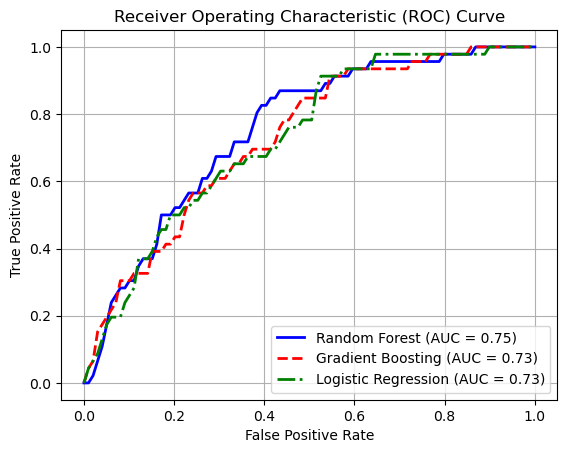

In [88]:
# Performing spline interpolation
interp_fpr_rf = np.linspace(0, 1, 100)
interp_tpr_rf = interp1d(fpr_rf, tpr_rf)(interp_fpr_rf)

interp_fpr_gbt = np.linspace(0, 1, 100)
interp_tpr_gbt = interp1d(fpr_gbt, tpr_gbt)(interp_fpr_gbt)

interp_fpr_lr = np.linspace(0, 1, 100)
interp_tpr_lr = interp1d(fpr_lr, tpr_lr)(interp_fpr_lr)

# Plotting the ROC curves
plt.figure()

plt.plot(interp_fpr_rf, interp_tpr_rf, linestyle='-', color='b', linewidth=2, label=f'Random Forest (AUC = {auc(interp_fpr_rf, interp_tpr_rf):.2f})')
plt.plot(interp_fpr_gbt, interp_tpr_gbt, linestyle='--', color='r', linewidth=2, label=f'Gradient Boosting (AUC = {auc(interp_fpr_gbt, interp_tpr_gbt):.2f})')
plt.plot(interp_fpr_lr, interp_tpr_lr, linestyle='-.', color='g', linewidth=2, label=f'Logistic Regression (AUC = {auc(interp_fpr_lr, interp_tpr_lr):.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [160]:
train_df.unpersist()

DataFrame[features: vector, class: float]

In [161]:
test_df.unpersist()

DataFrame[features: vector, class: float]

In [119]:
# Splitting data into training and test sets
train_df, test_df = updated_df.randomSplit([0.8, 0.2], seed=42)

# Handling class imbalance using undersampling method
train_df = train_df.sampleBy("class", fractions={0: 0.02, 1: 1.0}, seed=42)

train_df = train_df.repartition(40)

In [120]:
# Assemble features and cache
feature_columns = updated_df.columns[:-1]  # Excluding the target column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_df = assembler.transform(train_df).select("features", "class").cache()
test_df = assembler.transform(test_df).select("features", "class").cache()

In [121]:
# Collecting data needed for model fitting
data = train_df.rdd.map(lambda row: (row.features, row['class'])).toDF(["features", "class"])

num_models = 10

# Fitting models on the driver
models = []
for _ in range(num_models):  
    
    # Sampling the data 
    sampled_data = data.sample(withReplacement=True, fraction=1.0, seed=42)
    
    # Creating a new RandomForestClassifier instance with the best hyperparameters
    rf2 = RandomForestClassifier(featuresCol="features", labelCol="class", 
                                 numTrees=500,maxDepth=5,minInstancesPerNode=20, probabilityCol="probability") 
    model = rf2.fit(sampled_data)
    models.append(model)


In [122]:
# predictions using each model
#predictions = [model.transform(test_df).select("prediction") for model in models]
predictions = [model.transform(test_df).select("prediction", "rawPrediction") for model in models]

# Aggregating predictions
combined_predictions = reduce(lambda x, y: x.union(y), predictions)


In [123]:
# Adding an identifier column to the combined predictions DataFrame
combined_predictions = combined_predictions.withColumn("id", monotonically_increasing_id())

# Adding an identifier column to the test_df DataFrame
test_df = test_df.withColumn("id", monotonically_increasing_id())

# Joining the combined predictions with the true labels based on the "id" column
final_predictions = combined_predictions.join(test_df.select("id", "class"), "id", "inner")

# Casting the "prediction" column to DoubleType
final_predictions = final_predictions.withColumn("prediction", final_predictions["prediction"].cast("double"))

In [124]:
# Evaluating AUC
evaluator = BinaryClassificationEvaluator(labelCol="class", metricName="areaUnderROC")
aucrf2 = evaluator.evaluate(final_predictions)
print("AUC:", aucrf2)

AUC: 0.7184082921114294


In [125]:
# Printing classification report
y_true = final_predictions.select("class").collect()
y_predrf2 = final_predictions.select("prediction").collect()

print(classification_report(y_true, y_predrf2))

              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87      2672
         1.0       0.04      0.50      0.07        46

    accuracy                           0.76      2718
   macro avg       0.51      0.63      0.47      2718
weighted avg       0.97      0.76      0.85      2718



C:\Anaconda3\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


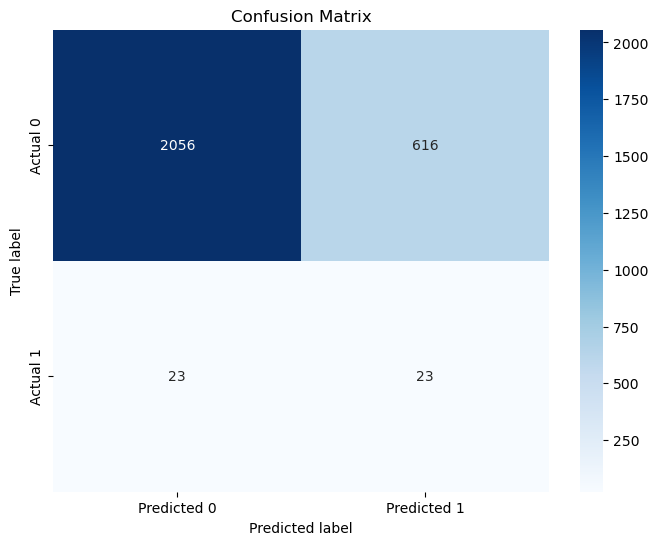

In [126]:
# Confusion matrix for bagging model

# Converting predictions to RDD for MulticlassMetrics
prediction_and_labelrf2 = final_predictions.select("prediction", "class").rdd.map(lambda x: (x[0], x[1]))

# MulticlassMetrics
metricsrf2 = MulticlassMetrics(prediction_and_labelrf2)

# Calculating confusion matrix
cmrf2 = metricsrf2.confusionMatrix().toArray()

# Ploting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmrf2, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [127]:
train_df.unpersist()

DataFrame[features: vector, class: float]

In [128]:
test_df.unpersist()

DataFrame[features: vector, class: float, id: bigint]

In [108]:
# Splitting data into training and test sets
train_df, test_df = updated_df.randomSplit([0.8, 0.2], seed=42)

# Handling class imbalance by undersampling majority class
train_df = train_df.sampleBy("class", fractions={0: 0.02, 1: 1.0}, seed=42)

# Calculating class weights
class_counts = train_df.groupBy("class").count()
total_count = train_df.count()
class_weights = class_counts.withColumn("weight", total_count / (2 * class_counts["count"]))

# Joining class weights with train data
train_df = train_df.join(class_weights.select("class", "weight"), on="class")

train_df = train_df.repartition(40)

In [65]:
train_df.printSchema()

root
 |-- class: float (nullable = true)
 |-- propensity: float (nullable = true)
 |-- PSSM_r2_4_V: float (nullable = true)
 |-- PSSM_r2_4_M: float (nullable = true)
 |-- PSSM_r1_3_H: float (nullable = true)
 |-- PSSM_r2_-2_M: float (nullable = true)
 |-- PSSM_r1_2_C: float (nullable = true)
 |-- length: float (nullable = true)
 |-- PSSM_central_0_A: float (nullable = true)
 |-- PredSA_freq_global_1: float (nullable = true)
 |-- PSSM_r1_0_A: float (nullable = true)
 |-- weight: double (nullable = true)



In [109]:
# Assemble features and cache
feature_columns = updated_df.columns[:-1]  # Excluding the target column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_df = assembler.transform(train_df).select("features", "class", "weight").cache()
test_df = assembler.transform(test_df).select("features", "class").cache()

In [111]:
# Collecting data needed for model fitting
data = train_df.rdd.map(lambda row: (row.features, row['class'],row['weight'])).toDF(["features", "class","weight"])

num_models = 10

# Fitting models on the driver
models = []
for _ in range(num_models): 
    
    # Sampling the data 
    sampled_data = data.sample(withReplacement=True, fraction=1.0, seed=42)
    # Creating a new RandomForestClassifier instance with the best hyperparameters
    rf2 = RandomForestClassifier(featuresCol="features", labelCol="class",weightCol="weight", 
                                 numTrees=500,maxDepth=5,minInstancesPerNode=20, probabilityCol="probability") 
    model = rf2.fit( sampled_data)
    models.append(model)


In [112]:
# predictions using each model
predictions = [model.transform(test_df).select("prediction", "rawPrediction") for model in models]

# Aggregating the predictions
combined_predictions = reduce(lambda x, y: x.union(y), predictions)


In [113]:
# Adding an identifier column to the combined predictions DataFrame
combined_predictions = combined_predictions.withColumn("id", monotonically_increasing_id())

# Adding an identifier column to the test_df DataFrame
test_df = test_df.withColumn("id", monotonically_increasing_id())

# Joining the combined predictions with the true labels based on the "id" column
final_predictions = combined_predictions.join(test_df.select("id", "class"), "id", "inner")

# Casting the "prediction" column to DoubleType
final_predictions = final_predictions.withColumn("prediction", final_predictions["prediction"].cast("double"))

In [114]:
# Evaluating AUC
evaluator = BinaryClassificationEvaluator(labelCol="class", metricName="areaUnderROC")
aucrf2 = evaluator.evaluate(final_predictions)
print("AUC:", aucrf2)

AUC: 0.7462290093725606


In [115]:
# Printing classification report
y_true = final_predictions.select("class").collect()
y_predrf2 = final_predictions.select("prediction").collect()

print(classification_report(y_true, y_predrf2))

              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77      2672
         1.0       0.03      0.76      0.07        46

    accuracy                           0.63      2718
   macro avg       0.51      0.70      0.42      2718
weighted avg       0.98      0.63      0.76      2718



C:\Anaconda3\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


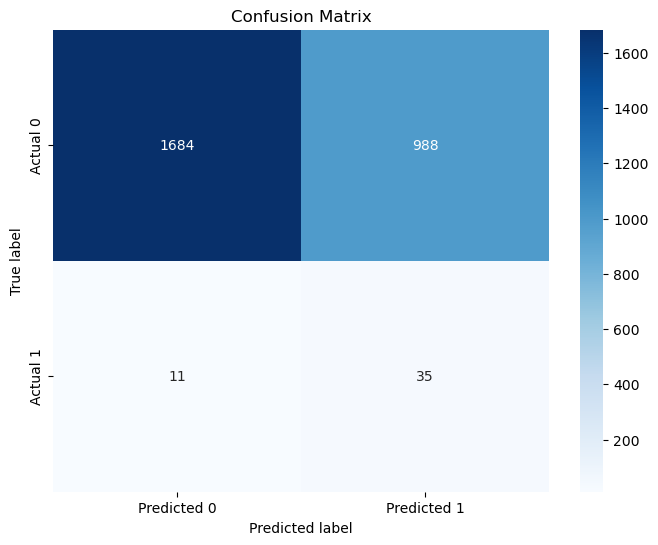

In [116]:
# Confusion matrix for bagging model with class weights

# Converting predictions to RDD for MulticlassMetrics
prediction_and_labelrf2 = final_predictions.select("prediction", "class").rdd.map(lambda x: (x[0], x[1]))

# MulticlassMetrics
metricsrf2 = MulticlassMetrics(prediction_and_labelrf2)

# Calculating confusion matrix
cmrf2 = metricsrf2.confusionMatrix().toArray()

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmrf2, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [117]:
train_df.unpersist()

DataFrame[features: vector, class: float, weight: double]

In [118]:
test_df.unpersist()

DataFrame[features: vector, class: float, id: bigint]

In [ ]:
# Stopping the spark
spark.stop()

In [162]:
# Splitting data into training and test sets
train_df, test_df = updated_df.randomSplit([0.8, 0.2], seed=42)

# Handling class imbalance by undersampling majority class
train_df = train_df.sampleBy("class", fractions={0: 0.04, 1: 1.0}, seed=42)

# Calculating class weights
class_counts = train_df.groupBy("class").count()
total_count = train_df.count()
class_weights = class_counts.withColumn("weight", total_count / (2 * class_counts["count"]))

# Joining class weights with train data
train_df = train_df.join(class_weights.select("class", "weight"), on="class")

train_df = train_df.repartition(40)

In [163]:
# Assemble features and cache
feature_columns = updated_df.columns[:-1]  # Excluding the target column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_df = assembler.transform(train_df).select("features", "class", "weight").cache()
test_df = assembler.transform(test_df).select("features", "class").cache()

In [164]:
# Collecting data needed for model fitting
data = train_df.rdd.map(lambda row: (row.features, row['class'],row['weight'])).toDF(["features", "class","weight"])

num_models = 10

# Fitting models on the driver
models = []
for _ in range(num_models): 
    
    # Sampling the data 
    sampled_data = data.sample(withReplacement=True, fraction=1.0, seed=42)
    # Creating a new RandomForestClassifier instance with the best hyperparameters
    rf2 = RandomForestClassifier(featuresCol="features", labelCol="class",weightCol="weight", 
                                 numTrees=500,maxDepth=5,minInstancesPerNode=20, probabilityCol="probability") 
    model = rf2.fit( sampled_data)
    models.append(model)


In [165]:
# predictions using each model
predictions = [model.transform(test_df).select("prediction", "rawPrediction") for model in models]

# Aggregating the predictions
combined_predictions = reduce(lambda x, y: x.union(y), predictions)


In [166]:
# Adding an identifier column to the combined predictions DataFrame
combined_predictions = combined_predictions.withColumn("id", monotonically_increasing_id())

# Adding an identifier column to the test_df DataFrame
test_df = test_df.withColumn("id", monotonically_increasing_id())

# Joining the combined predictions with the true labels based on the "id" column
final_predictions = combined_predictions.join(test_df.select("id", "class"), "id", "inner")

# Casting the "prediction" column to DoubleType
final_predictions = final_predictions.withColumn("prediction", final_predictions["prediction"].cast("double"))

In [167]:
# Evaluating AUC
evaluator = BinaryClassificationEvaluator(labelCol="class", metricName="areaUnderROC")
aucrf3 = evaluator.evaluate(final_predictions)
print("AUC:", aucrf3)

AUC: 0.6935937906795107


In [168]:
# Printing classification report
y_true = final_predictions.select("class").collect()
y_predrf3 = final_predictions.select("prediction").collect()

print(classification_report(y_true, y_predrf3))

              precision    recall  f1-score   support

         0.0       0.99      0.67      0.80      2672
         1.0       0.03      0.61      0.06        46

    accuracy                           0.67      2718
   macro avg       0.51      0.64      0.43      2718
weighted avg       0.97      0.67      0.78      2718



C:\Anaconda3\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


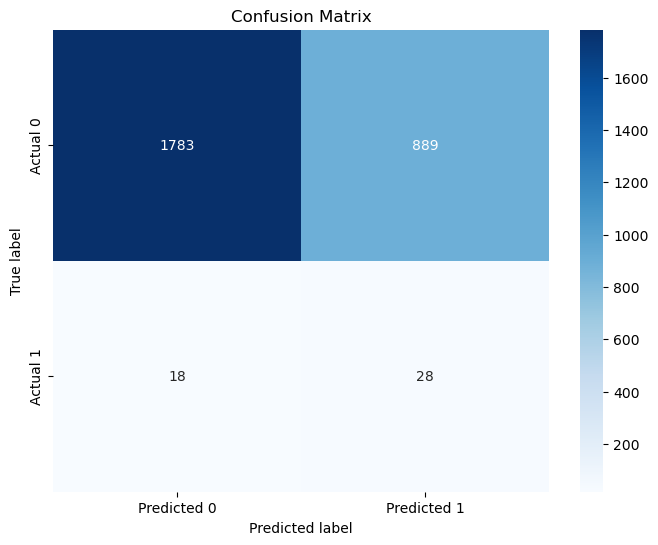

In [172]:
# Confusion matrix


# Converting predictions to RDD for MulticlassMetrics
prediction_and_labelrf3 = final_predictions.select("prediction", "class").rdd.map(lambda x: (x[0], x[1]))

# MulticlassMetrics
metricsrf3 = MulticlassMetrics(prediction_and_labelrf3)

# Calculating confusion matrix
cmrf3 = metricsrf3.confusionMatrix().toArray()

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmrf3, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [173]:
train_df.unpersist()

DataFrame[features: vector, class: float, weight: double]

In [174]:
test_df.unpersist()

DataFrame[features: vector, class: float, id: bigint]

In [175]:
spark.stop()